In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import datetime as dt
from os import listdir
from os.path import isfile, join
from siphon.simplewebservice.wyoming import WyomingUpperAir
import math

In [2]:
def commas_to_dots(file_name, replace_from,replace_to):
    data = ""
    with open(file_name, 'r') as file:
        data = file.read().replace(replace_from, replace_to)
    with open(file_name, "w") as out_file:
        out_file.write(data)

In [3]:
location_mes = "Moscow"
curr_date = '20.04.2022'

In [4]:
pressures_mk = np.flip(np.array([2.437E-05,   6.460E-05,   2.930E-04,   6.936E-04,   1.610E-03, 
               3.633E-03,   8.511E-03,   1.964E-02,   4.424E-02,   9.367E-02, 
               1.903E-01,   3.697E-01,   7.059E-01,   9.135E-01,   1.183E+00, 
               1.535E+00,   1.999E+00,   2.616E+00,   3.443E+00,   4.562E+00, 
               6.096E+00,   8.205E+00,   1.112E+01,   1.516E+01,   2.078E+01, 
               2.852E+01,   3.918E+01,   5.387E+01,   7.393E+01,   1.011E+02, 
               1.380E+02,   1.885E+02,   2.579E+02,   3.008E+02,   3.494E+02, 
               4.042E+02,   4.653E+02,   5.334E+02,   6.096E+02,   6.944E+02, 
               7.893E+02,   8.944E+02,   9.976E+02]))

altitudes_mk = np.flip(np.array([120.000,     110.000,     100.000,      95.000,      90.000, 
              85.000,      80.000,      75.000,      70.000,      65.000, 
              60.000,      55.000,      50.000,      48.000,      46.000, 
              44.000,      42.000,      40.000,      38.000,      36.000, 
              34.000,      32.000,      30.000,      28.000,      26.000, 
              24.000,      22.000,      20.000,      18.000,      16.000, 
              14.000,      12.000,      10.000,       9.000,       8.000, 
               7.000,       6.000,       5.000,       4.000,       3.000, 
               2.000,       1.000,       0.020]))

temperature_mk = np.flip(np.array([4.194E+02,   2.747E+02,   1.955E+02,   1.943E+02,   2.000E+02, 
               2.009E+02,   1.979E+02,   2.042E+02,   2.170E+02,   2.310E+02, 
               2.445E+02,   2.547E+02,   2.601E+02,   2.603E+02,   2.591E+02, 
               2.563E+02,   2.522E+02,   2.473E+02,   2.419E+02,   2.360E+02, 
               2.299E+02,   2.242E+02,   2.196E+02,   2.161E+02,   2.138E+02, 
               2.128E+02,   2.130E+02,   2.140E+02,   2.157E+02,   2.178E+02, 
               2.191E+02,   2.173E+02,   2.195E+02,   2.243E+02,   2.307E+02, 
               2.378E+02,   2.449E+02,   2.518E+02,   2.582E+02,   2.640E+02, 
               2.691E+02,   2.744E+02,   2.784E+02]))

if location_mes == "Moscow" or "Kal_obl" or "Obninsk":
    station = '27713' #moscow
elif location_mes == "Nikel":
    station = '22008' #murmansk

dt_1 = dt.datetime(2023, 1, 1, 0)
df = WyomingUpperAir.request_data(dt_1, station)

balloon_pressure = np.array(df['pressure'])*0.0009869233
balloon_temperature = np.array(df['temperature'])+273.15
balloon_height = np.array(df['height'])/1000
balloon_speed_u = np.array(df['u_wind'])*0.514444
balloon_speed_v = np.array(df['v_wind'])*0.514444

for i in range(0, len(altitudes_mk)):
    if altitudes_mk[i] > balloon_height[-1]:
        nearest_balloon_ind = i
        break

temporary_altitude = np.concatenate((balloon_height, altitudes_mk[nearest_balloon_ind:]))
temporary_pressure = np.concatenate((balloon_pressure, pressures_mk[nearest_balloon_ind:]*0.0009869233))
temporary_temp = np.concatenate((balloon_temperature, temperature_mk[nearest_balloon_ind:]))

column_height = np.linspace(0, 110, 100)

pressure_interp = scipy.interpolate.interp1d(temporary_altitude, temporary_pressure, kind='cubic',
                                           fill_value = 'extrapolate')
column_pressure = pressure_interp(column_height)

temperature_interp = scipy.interpolate.interp1d(temporary_altitude, temporary_temp, kind='cubic',
                                           fill_value = 'extrapolate')
column_temp = temperature_interp(column_height)

#water_interp = scipy.interpolate.interp1d(simulation_data[:, 0], simulation_data[:, 3], kind='cubic',
#                                           fill_value = 'extrapolate')
#column_water_c = water_interp(column_height)

height_len = len(column_height)

In [5]:
def refraction(P,T,lamb):
    return 1+1e-6*(776.2+4.36e-8*lamb**2)*P*101.325/T

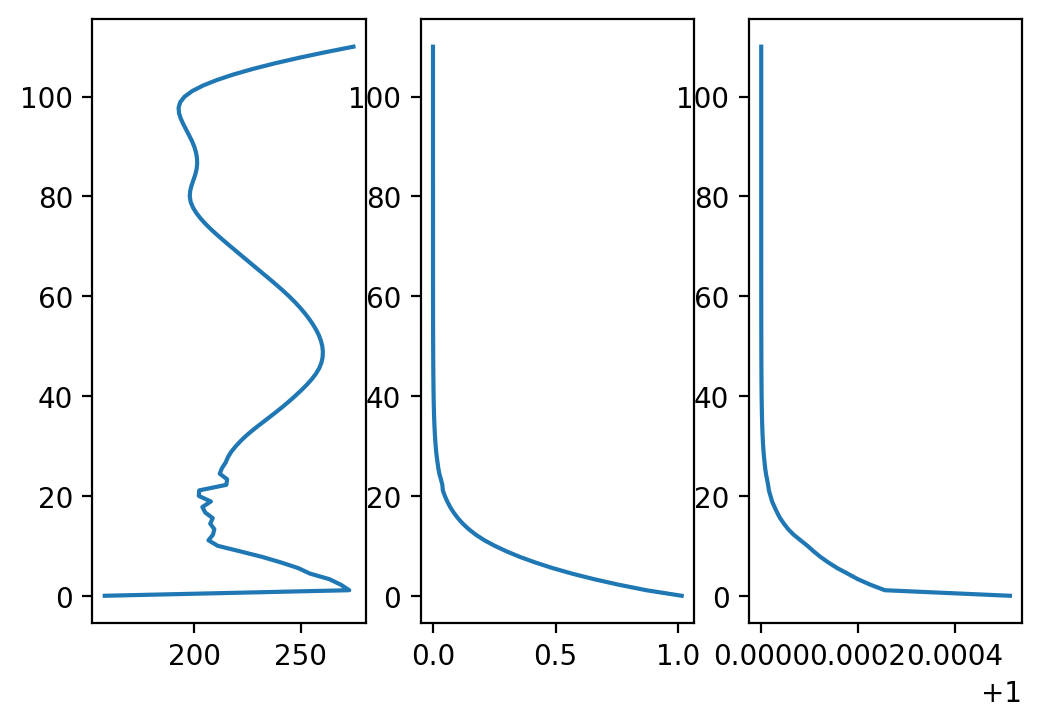

In [6]:
plt.figure(dpi=200)
plt.rcParams['figure.figsize'] = [10, 4]
plt.subplot(1,3,1)
plt.plot(column_temp,column_height)#, temporary_temp-273.15, temporary_altitude)
plt.subplot(1,3,2)
plt.plot(column_pressure,column_height)#,temporary_pressure,temporary_altitude)
plt.subplot(1,3,3)
refraction_profile = refraction(column_pressure, column_temp, 18181)
plt.plot(refraction_profile,column_height)#,temporary_pressure,temporary_altitude)
plt.show()

from pyatmos import download_sw_nrlmsise00,read_sw_nrlmsise00
swfile = download_sw_nrlmsise00() 
swdata = read_sw_nrlmsise00(swfile)

In [7]:
R_const = 8.31446
M_air = 0.0289652

from pyatmos import nrlmsise00
t = '2014-07-22 22:18:45' # time(UTC) 
lat,lon,alt = 25,102,0 # latitude, longitude in [degree], and altitude in [km]
nrl00 = nrlmsise00(t,(lat,lon,alt),swdata)
print(nrl00.rho*R_const*nrl00.T/M_air*9.8692e-6) # [kg/m^3]
print(nrl00.T-273.15) # [K]
#print(nrl00.nd) # composition in [1/m^3]

In [8]:
def find_intersection(circle_center, circle_radius, line_point):
    # Extract circle coordinates
    cx, cy = circle_center

    # Extract line coordinates
    x1, y1 = line_point[0]
    x2, y2 = line_point[1]

    # Calculate line slope (m) and y-intercept (b)
    if x2 - x1 != 0:
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
    else:
        m = None
        b = x1  # Vertical line case

    # Calculate the coefficients for the quadratic equation
    A = 1 + m**2
    B = 2 * (m * b - m * cy - cx)
    C = cx**2 + (b - cy)**2 - circle_radius**2

    # Calculate the discriminant
    discriminant = B**2 - 4 * A * C

    # Check if the discriminant is negative, indicating no intersections
    if discriminant < 0:
        return []

    # Calculate intersection points
    x_intersect1 = (-B + discriminant**0.5) / (2 * A)
    x_intersect2 = (-B - discriminant**0.5) / (2 * A)
    y_intersect1 = m * x_intersect1 + b if m is not None else y1
    y_intersect2 = m * x_intersect2 + b if m is not None else y2

    # Format the result as a list of tuples with (x, y) coordinates
    intersections = [[x_intersect1, y_intersect1], [x_intersect2, y_intersect2]]
    return intersections

def find_angle(circle_center, intersection_point):
    # Calculate the vector representing the circle radius at the point of intersection
    radius_vector = (intersection_point[0][0] - circle_center[0], intersection_point[0][1] - circle_center[1])

    # Calculate the vector representing the intersection line
    line_vector = (intersection_point[1][0] - intersection_point[0][0], intersection_point[1][1] - intersection_point[0][1])

    # Calculate the dot product between the two vectors
    dot_product = radius_vector[0] * line_vector[0] + radius_vector[1] * line_vector[1]

    # Calculate the magnitude of each vector
    magnitude_radius = math.sqrt(radius_vector[0]**2 + radius_vector[1]**2)
    magnitude_line = math.sqrt(line_vector[0]**2 + line_vector[1]**2)

    # Calculate the angle between the vectors in radians
    angle_radians = math.acos(dot_product / (magnitude_radius * magnitude_line))

    # Convert the angle to degrees
    angle_degrees = 180-math.degrees(angle_radians)

    return angle_radians

def find_line_coord_from_angle(intersection_point, circle_center, circle_radius, angle_rad):

    # Step 1: Calculate the slope of the line passing through the intersection point and the center of the circle
    dx = circle_center[0] - intersection_point[0]
    dy = circle_center[1] - intersection_point[1]
    line_slope = dy / dx

    # Step 2: Calculate the angle between the line and the x-axis
    line_angle_rad = math.atan(line_slope)

    # Step 3: Add the given angle to the angle between the line and the x-axis
    other_point_angle_rad = line_angle_rad - angle_rad

    # Step 4: Use trigonometry to calculate the x and y coordinates of the other point on the line
    other_point_x = intersection_point[0] + circle_radius * math.cos(other_point_angle_rad)
    other_point_y = intersection_point[1] + circle_radius * math.sin(other_point_angle_rad)

    return [[intersection_point[0],intersection_point[1]],[other_point_x, other_point_y]]

def angle_between_lines(line1, line2):
    # Extract direction vectors from the lines
    direction_vector1 = np.array(line1[1]) - np.array(line1[0])
    direction_vector2 = np.array(line2[1]) - np.array(line2[0])

    # Calculate the dot product of the direction vectors
    dot_product = np.dot(direction_vector1, direction_vector2)

    # Calculate the magnitudes of the direction vectors
    magnitude1 = np.linalg.norm(direction_vector1)
    magnitude2 = np.linalg.norm(direction_vector2)

    # Calculate the angle in radians
    angle_radians = np.arccos(dot_product / (magnitude1 * magnitude2))

    # Convert the angle from radians to degrees
    angle_degrees = np.degrees(angle_radians)

    return angle_degrees


<Figure size 3000x1200 with 0 Axes>

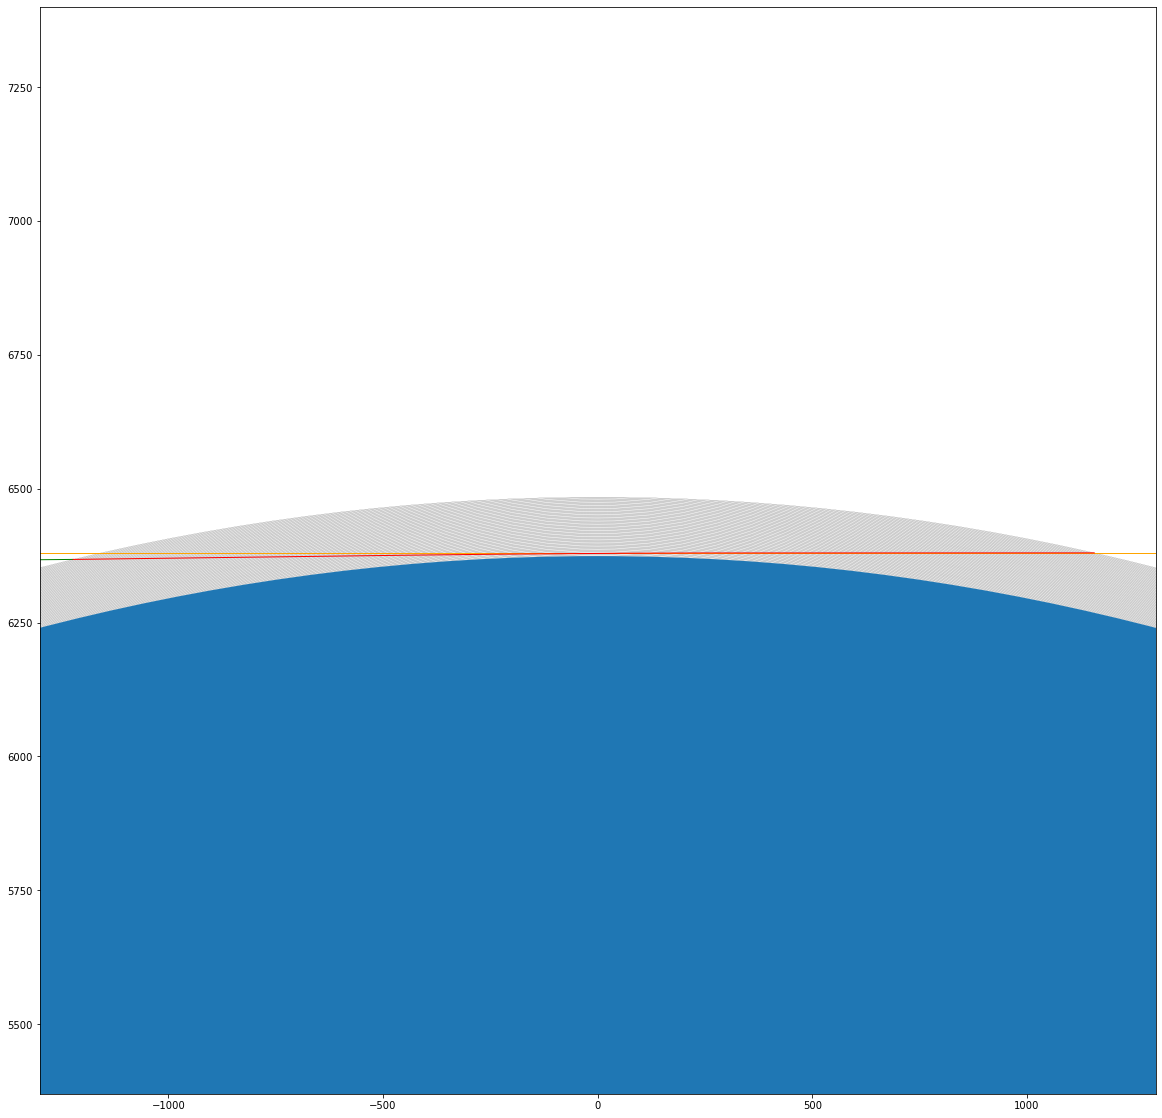

In [9]:
plt.figure(dpi=300)
plt.rcParams['figure.figsize'] = [20, 20]
fig, ax = plt.subplots()
line_width_param = 1

#define layer coordinates and initial beam
earth_coord = [0,0,6374]
atm_layers = np.zeros((3,len(column_height)))
atm_layers[0][:] = 0
atm_layers[1][:] = 0
atm_layers[2][:] = earth_coord[2]+column_height
sun_beam = [[6400,6380],[-6400,6380]]

#plot the earth, atmosphere and initial beam
circle_earth = plt.Circle((earth_coord[0], earth_coord[1]), earth_coord[2])
for i in range(len(atm_layers[0])):
    circle_atmosphere = plt.Circle((atm_layers[0][i], atm_layers[1][i]), atm_layers[2][i], 
                                   fill=False, alpha=1, linewidth = 0.1)
    ax.add_patch(circle_atmosphere)
ax.add_patch(circle_earth)
sun_beam_x, sun_beam_y = zip(*sun_beam)
plt.plot(sun_beam_x,sun_beam_y, linewidth = line_width_param, color = 'orange')

#find line intersections
refr_ind = refraction_profile
ray_middle_flag = True
k = 0
current_beam = sun_beam
intersections_arr = np.empty((0, 2))

#beam going through first half of the atmosphere
while(1):
    intersections = find_intersection(atm_layers[0:2,-1-k], atm_layers[2,-1-k], current_beam)
    if intersections == []:
        k = k - 1 #to go to previous relevant layer
        break
        #exiting with the last beam that doesnt intersect with next layer
    intersections_x, intersections_y = zip(*intersections)
    intersections_arr = np.vstack((intersections_arr, intersections[0]))
    z1 = np.pi - find_angle(atm_layers[0:2,-1-k], intersections)
    n1 = refr_ind[-1-k]
    n2 = refr_ind[-2-k]
    z2 = np.arcsin(n1/n2*np.sin(z1))

    raytraced_vector = find_line_coord_from_angle(intersections[0], atm_layers[0:2,-1-k], atm_layers[2,-1-k], z2+np.pi)
    raytraced_vector_x, raytraced_vector_y = zip(*raytraced_vector)
    current_beam = raytraced_vector
    k = k + 1

#beam going through second half of the atmosphere
while(k >= 0):
    intersections = find_intersection(atm_layers[0:2,-1-k], atm_layers[2,-1-k], current_beam)
    intersections_x, intersections_y = zip(*intersections)
    intersections_arr = np.vstack((intersections_arr, intersections[1]))
    z1 = np.pi - find_angle(atm_layers[0:2,-1-k], intersections)
    n1 = refr_ind[-1-k]
    n2 = refr_ind[-1-k+1]
    z2 = np.arcsin(n1/n2*np.sin(z1))

    raytraced_vector = find_line_coord_from_angle(intersections[1], atm_layers[0:2,-1-k], atm_layers[2,-1-k], -z2+np.pi)
    raytraced_vector_x, raytraced_vector_y = zip(*raytraced_vector)
    current_beam = raytraced_vector
    k = k - 1
plt.plot(raytraced_vector_x, raytraced_vector_y, linewidth = line_width_param, color = 'green')
intersections_x, intersections_y = zip(*intersections_arr)
plt.plot(intersections_x, intersections_y, linewidth = line_width_param, color = 'red')

plt.xlim([-1300,1300])
plt.ylim([6370-1000,6400+1000])
plt.show()

nan


<ipython-input-10-4a685014a9a1>:40: RuntimeWarning: invalid value encountered in arcsin
  z2 = np.arcsin(n1/n2*np.sin(z1))


<Figure size 20000x20000 with 0 Axes>

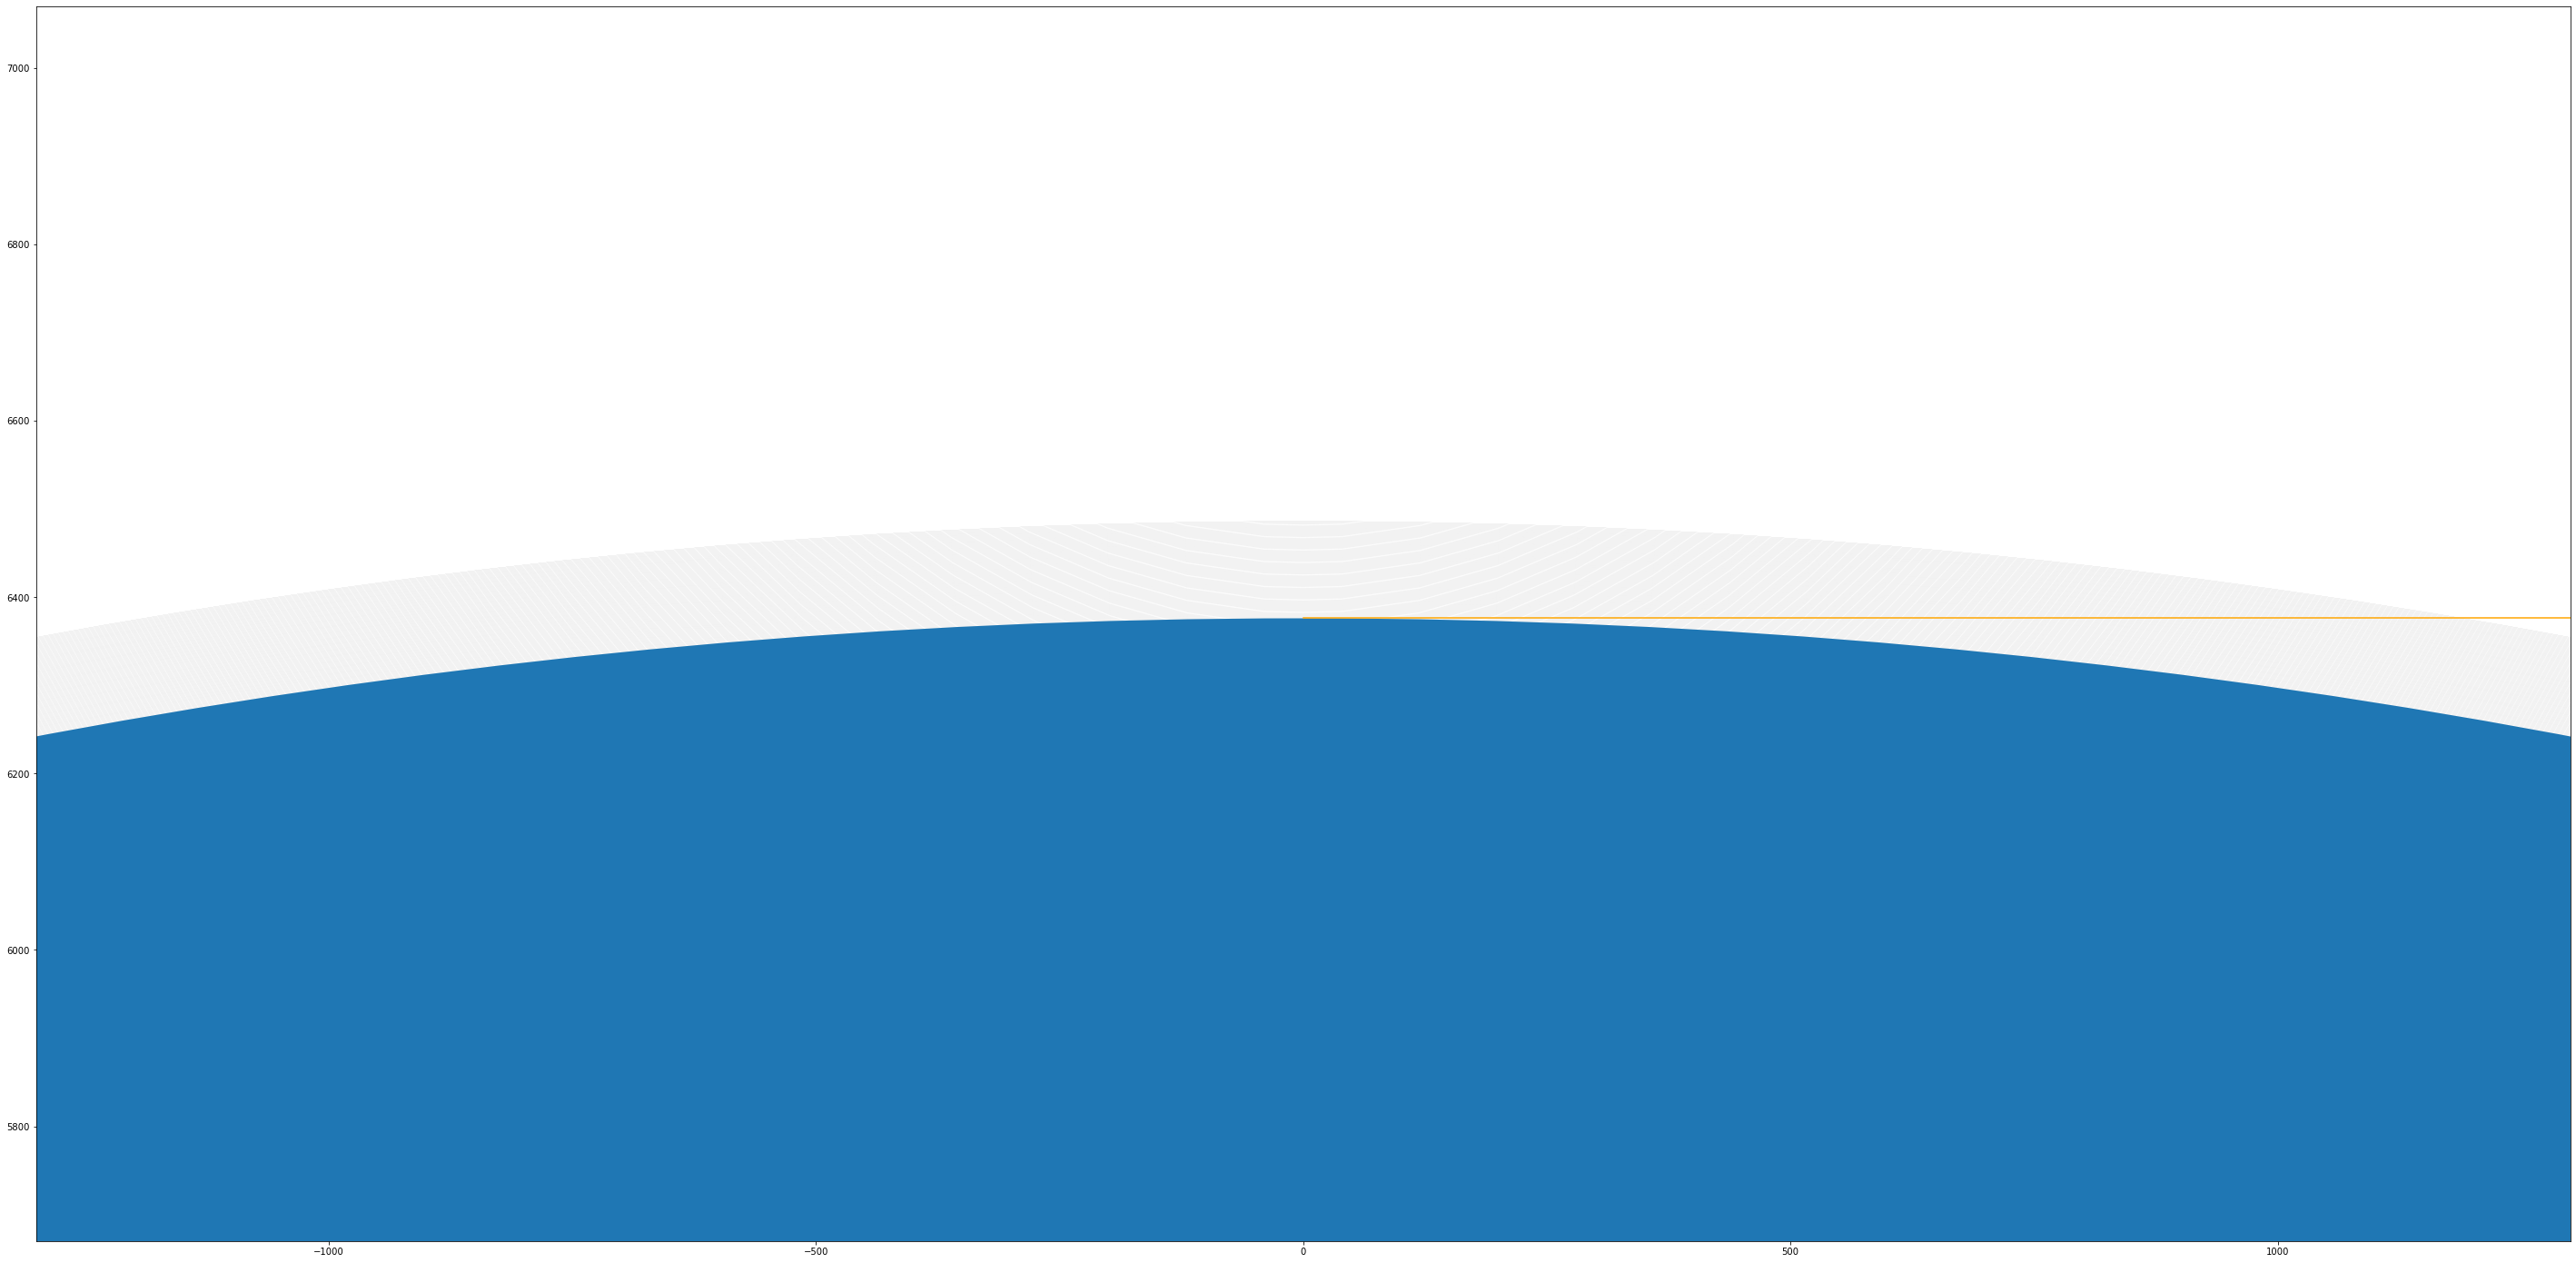

In [10]:
plt.figure(dpi=1000)
plt.rcParams['figure.figsize'] = [50, 25]
fig, ax = plt.subplots()
line_width_param = 1.5
plt.xlim([-1300,1300])
plt.ylim([6370-700,6370+700])

#define layer coordinates and initial beam
earth_coord = [0,0,6376]
atm_layers = np.zeros((3,len(column_height)))
atm_layers[0][:] = 0
atm_layers[1][:] = 0
atm_layers[2][:] = earth_coord[2]+column_height
sun_beam = [[0,6376],[6000,6376]]

#plot the earth, atmosphere and initial beam
circle_earth = plt.Circle((earth_coord[0], earth_coord[1]), earth_coord[2])
for i in range(len(atm_layers[0])):
    circle_atmosphere = plt.Circle((atm_layers[0][i], atm_layers[1][i]), atm_layers[2][i], 
                                   fill=False, alpha=0.5, linewidth = 0.1)
    ax.add_patch(circle_atmosphere)
ax.add_patch(circle_earth)
sun_beam_x, sun_beam_y = zip(*sun_beam)
plt.plot(sun_beam_x,sun_beam_y, linewidth = line_width_param, color = 'orange')

#find line intersections
refr_ind = refraction_profile
ray_middle_flag = True
current_beam = sun_beam
intersections_arr = np.empty((0, 2))

k = 1
while(k < len(refr_ind)):
    intersections = find_intersection(atm_layers[0:2,k], atm_layers[2,k], current_beam)
    intersections_x, intersections_y = zip(*intersections)
    intersections_arr = np.vstack((intersections_arr, intersections[0]))
    z1 = np.pi - find_angle(atm_layers[0:2,k], intersections)
    n1 = refr_ind[k-1]
    n2 = refr_ind[k]
    z2 = np.arcsin(n1/n2*np.sin(z1))

    raytraced_vector = find_line_coord_from_angle(intersections[0], atm_layers[0:2,k], atm_layers[2,k], z2+np.pi)
    raytraced_vector_x, raytraced_vector_y = zip(*raytraced_vector)
    current_beam = raytraced_vector
    k = k + 1
print(180 - angle_between_lines(current_beam, sun_beam))
#plt.plot(raytraced_vector_x, raytraced_vector_y, linewidth = line_width_param, color = 'green')
intersections_x, intersections_y = zip(*intersections_arr)
plt.plot(intersections_x, intersections_y, linewidth = line_width_param, color = 'green')

plt.show()